In [12]:
from gradient import *
from torch.optim.optimizer import Optimizer

from contextlib import contextmanager
import sys, os


torch.manual_seed(1)    # reproducible
device = torch.device('cuda')
model = torch.nn.Sequential(
        torch.nn.Linear(1, 10),
        torch.nn.ELU(),                                       
        torch.nn.Linear(10, 1),
    ).to(device)

inputs = torch.unsqueeze(torch.linspace(-10, 10, 1000), dim=1).to(device)
targets = torch.sin(inputs) + 0.2*torch.rand(inputs.size()).to(device)
ntp = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of Trainable Params: {}'.format(ntp))
dg = torch.tensor([0.01]*ntp,device='cuda:0') 
cos = torch.nn.CosineSimilarity(dim=0).to('cuda:0')

class LM(Optimizer):
    def __init__(self, params, lr=1, alpha=1, eps=0.9, dP=0.6):
        defaults = dict(
            lr = lr,
            alpha = alpha,
            prev_dw = None,
            prev_dw1 = None,
            eps = eps,
            dP = dP,
            min_loss = 1e10,
        )
        super(LM, self).__init__(params, defaults)

        if len(self.param_groups) != 1:
            raise ValueError ("LM doesn't support per-parameter options") 
        self._params = self.param_groups[0]['params']
        
    def step(self, closure=None,dg_prev=None,cos=None):
        assert len(self.param_groups) == 1
        group = self.param_groups[0]
        lr = group['lr']
        alpha = group['alpha']
        eps = group['eps']
        dP = group['dP']
        prev_dw = group['prev_dw']
        prev_dw1 = group['prev_dw']
        


        prev_loss, g, H = closure(sample=True)
        group['min_loss'] = torch.min(torch.tensor([group['min_loss'],prev_loss]))
        print(group['min_loss'])
        # H += torch.eye(H.shape[0]).to(device)*alpha
        dg = torch.diag(H)
        dg = torch.max(dg_prev,dg)
        H += torch.diag(dg).to(device)*alpha                 
        H_inv = torch.inverse(H)

        if prev_dw is None:
            delta_w = delta_w1 = (-H_inv @ g).detach()
            group['prev_dw1'] = delta_w1
        else:
            I_GG = torch.squeeze(g.T @ H_inv @ g)
            I_FF = torch.squeeze(prev_dw.T @ H @ prev_dw)
            I_GF = torch.squeeze(g.T @ prev_dw)
            dQ = -eps * dP * torch.sqrt(I_GG)
            t2 = 0.5 / torch.sqrt((I_GG * (dP**2) - dQ**2) / (I_FF*I_GG - I_GF*I_GF))
            t1 = (-2*t2*dQ + I_GF) / I_GG
            delta_w1 = -1*H_inv @ g
            group['prev_dw1'] = delta_w1
            print ('t1:{}'.format(t1))
            print ('t2:{}'.format(t2))
            delta_w = (t1/t2 * delta_w1  + 0.5/t2 * prev_dw).detach() 
    
        offset = 0
        for p in self._params:
            numel = p.numel()
            with torch.no_grad():
                p.add_(delta_w[offset:offset + numel].view_as(p),alpha=lr)
            offset += numel
      
        loss = closure(sample=False)
        group['prev_dw'] = delta_w

        #print ('loss:{}'.format(loss.item()))
        if loss < prev_loss:
            print('successful iteration')
            print(loss.item())
            if alpha >= 1e-5:
                group['alpha'] /= 10
            return loss.item(), dg        
        else:
            print('failed iteration')
            # undo the step
            offset = 0
            for p in self._params:    
                numel = p.numel()
                with torch.no_grad():
                    p.sub_(delta_w[offset:offset + numel].view_as(p),alpha=lr)
                offset += numel
            if True:
                loss_list = []
                line = torch.arange(1e-2,2,0.05)**3
                for i in range(len(line)):
                    offset = 0
                    for p in group['params']:
                        numel = p.numel()
                        with torch.no_grad():
                            p.add_(delta_w[offset:offset + numel].view_as(p),alpha=line[i])
                        offset += numel
                    loss = closure(sample=False)
                    loss_list.append(loss)
                    # # undo the step
                    offset = 0
                    for p in group['params']:
                        numel = p.numel()
                        with torch.no_grad():
                            p.sub_( delta_w[offset:offset + numel].view_as(p),alpha=line[i])
                        offset += numel

                idx_best_lr = torch.argmin(torch.tensor(loss_list))
                lr_best = line[idx_best_lr]
                print('best lr: {} '.format(lr_best))
                offset = 0
                for p in group['params']:
                    numel = p.numel()
                    with torch.no_grad():
                        p.add_(delta_w[offset:offset + numel].view_as(p),alpha=lr_best)
                    offset += numel   
            if alpha <= 1e5:
                group['alpha'] *= 10                                 
        
        return prev_loss.item() ,dg_prev

Number of Trainable Params: 31


In [13]:
optimizer = LM(model.parameters(),lr=1, alpha=1)
train_loss_momentum = []
for epoch in range(200):
    def closure(sample=True):
        out = model(inputs)
        diff = (out-targets).squeeze()
        if sample:
            J = jacobian(diff, model.parameters(), create_graph=True, retain_graph=True).detach()
            H = J.T @ J
            g = J.T @ diff
            loss = torch.mean(diff.detach()**2)
            return loss, g, H
        else:
            loss = torch.mean(diff.detach()**2)
            return loss
    optimizer.zero_grad()
    record_loss,dg = optimizer.step(closure,dg_prev=dg,cos=cos)
    train_loss_momentum.append(record_loss)

tion
0.43026044964790344
tensor(0.4303)
t1:0.09391667693853378
t2:1.385366678237915
successful iteration
0.4195171594619751
tensor(0.4195)
t1:0.5189276337623596
t2:7.768264293670654
failed iteration
best lr: 0.06892099976539612 
tensor(0.4179)
t1:1.4760757684707642
t2:20.142492294311523
failed iteration
best lr: 0.28749603033065796 
tensor(0.4126)
t1:0.7715275287628174
t2:8.253325462341309
successful iteration
0.4025249481201172
tensor(0.4025)
t1:0.2570679187774658
t2:3.5882561206817627
failed iteration
best lr: 0.438975989818573 
tensor(0.3917)
t1:0.9879440069198608
t2:9.141247749328613
successful iteration
0.3766561448574066
tensor(0.3767)
t1:0.09619434922933578
t2:1.56557035446167
successful iteration
0.3711378872394562
tensor(0.3711)
t1:0.2877991795539856
t2:3.833833932876587
failed iteration
best lr: 0.13265098631381989 
tensor(0.3688)
t1:0.6292068362236023
t2:8.926745414733887
successful iteration
0.3639334440231323
tensor(0.3639)
t1:0.41598236560821533
t2:5.495540142059326
faile

In [17]:
from gradient import *
from torch.optim.optimizer import Optimizer

from contextlib import contextmanager
import sys, os


torch.manual_seed(1)    # reproducible
device = torch.device('cuda')
model = torch.nn.Sequential(
        torch.nn.Linear(1, 10),
        torch.nn.ELU(),                                       
        torch.nn.Linear(10, 1),
    ).to(device)

inputs = torch.unsqueeze(torch.linspace(-10, 10, 1000), dim=1).to(device)
targets = torch.sin(inputs) + 0.2*torch.rand(inputs.size()).to(device)
ntp = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of Trainable Params: {}'.format(ntp))
dg = torch.tensor([0.01]*ntp,device='cuda:0') 
cos = torch.nn.CosineSimilarity(dim=0).to('cuda:0')

class LM(Optimizer):
    def __init__(self, params, lr=1, alpha=1, eps=0.9, dP=0.6):
        defaults = dict(
            lr = lr,
            alpha = alpha,
            prev_dw = None,
            prev_dw1 = None,
            eps = eps,
            dP = dP
        )
        super(LM, self).__init__(params, defaults)

        if len(self.param_groups) != 1:
            raise ValueError ("LM doesn't support per-parameter options") 
        self._params = self.param_groups[0]['params']
        
    def step(self, closure=None,dg_prev=None,cos=None):
        assert len(self.param_groups) == 1
        group = self.param_groups[0]
        lr = group['lr']
        alpha = group['alpha']
        eps = group['eps']
        dP = group['dP']
        prev_dw = group['prev_dw']
        prev_dw1 = group['prev_dw']

        prev_loss, g, H = closure(sample=True)
        H += torch.eye(H.shape[0]).to(device)*alpha        
        H_inv = torch.inverse(H)
        delta_w = (-H_inv @ g).detach()
    
        offset = 0
        for p in self._params:
            numel = p.numel()
            with torch.no_grad():
                p.add_(delta_w[offset:offset + numel].view_as(p),alpha=lr)
            offset += numel
      
        loss = closure(sample=False)
        group['prev_dw'] = delta_w

        #print ('loss:{}'.format(loss.item()))
        if loss < prev_loss:
            print('successful iteration')
            print(loss.item())
            group['alpha'] /= 10
            return loss.item(), dg
        else:
            print('failed iteration')
            group['alpha'] *= 10
            # undo the step
            offset = 0
            for p in self._params:    
                numel = p.numel()
                with torch.no_grad():
                    p.sub_(delta_w[offset:offset + numel].view_as(p),alpha=lr)
                offset += numel
        
        return prev_loss.item() ,dg_prev





Number of Trainable Params: 31


In [18]:
optimizer = LM(model.parameters(),lr=1, alpha=1)
train_loss = []
for epoch in range(200):
    def closure(sample=True):
        out = model(inputs)
        diff = (out-targets).squeeze()
        if sample:
            J = jacobian(diff, model.parameters(), create_graph=True, retain_graph=True).detach()
            H = J.T @ J
            g = J.T @ diff
            loss = torch.mean(diff.detach()**2)
            return loss, g, H
        else:
            loss = torch.mean(diff.detach()**2)
            return loss
    optimizer.zero_grad()
    record_loss, dg = optimizer.step(closure,dg_prev=dg,cos=cos)
    train_loss.append(record_loss)

failed iteration
failed iteration
successful iteration
0.4525836110115051
failed iteration
successful iteration
0.4403804838657379
failed iteration
successful iteration
0.42871740460395813
failed iteration
successful iteration
0.4137900471687317
failed iteration
successful iteration
0.39813411235809326
failed iteration
successful iteration
0.37984153628349304
successful iteration
0.2983073890209198
failed iteration
failed iteration
successful iteration
0.2699613869190216
failed iteration
successful iteration
0.2621062695980072
successful iteration
0.2617794871330261
failed iteration
failed iteration
successful iteration
0.23481379449367523
failed iteration
successful iteration
0.23188425600528717
failed iteration
successful iteration
0.2302456647157669
failed iteration
successful iteration
0.2288278341293335
failed iteration
successful iteration
0.22750434279441833
failed iteration
successful iteration
0.2262500673532486
failed iteration
successful iteration
0.22505682706832886
failed 

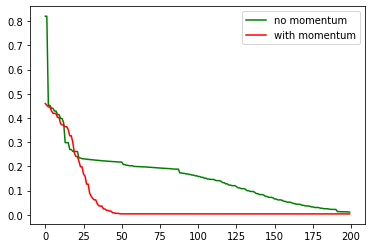

In [19]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label='no momentum', color='green')
plt.plot(train_loss_momentum, label='with momentum', color='red')
plt.legend()